阅读何凯明的基于暗通道先验的图像去雾论文，并用matlab或python复现其中去雾算法

Text(0.5, 1.0, '去雾图像')

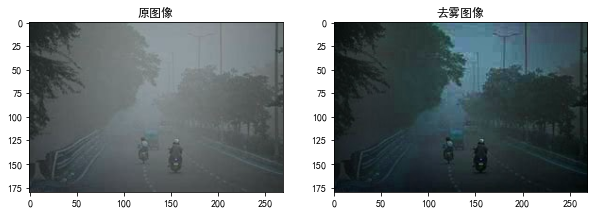

In [11]:
import cv2
import numpy as np
import numpy as np
import cv2
from matplotlib import pyplot as plt

# 定义最小值滤波，用腐蚀代替，r是滤波器半径
'''
cv2.erode(src, kernel[, anchor[, iterations[, borderType[, borderValue]]]] )
src 是需要腐蚀的原始图像
kernel 代表腐蚀操作时所采用的结构类型。
'''
def MinimumFilter(src, r=7):
    return cv2.erode(src, np.ones((2*r+1, 2*r+1))) 

# 引导滤波
'''
cv2.boxFilter（src,ddepth,ksize,anchor,normalize,borderType)
src  需要处理的图像 
ddepth  取-1表示与原始图像使用相同的图像深度
(r,r)  锚点
'''
def GuidedFilter(I, p, r, eps):
    height, width = I.shape
    m_I = cv2.boxFilter(I, -1, (r,r))
    m_p = cv2.boxFilter(p, -1, (r,r))
    m_Ip = cv2.boxFilter(I*p, -1, (r,r))
    cov_Ip = m_Ip-m_I*m_p
  
    m_II = cv2.boxFilter(I*I, -1, (r,r))
    var_I = m_II-m_I*m_I
  
    a = cov_Ip/(var_I+eps)
    b = m_p-a*m_I
  
    m_a = cv2.boxFilter(a, -1, (r,r))
    m_b = cv2.boxFilter(b, -1, (r,r))
    return m_a*I+m_b

# 返回大气遮罩图像V1和光照值A, V1 = 1-t/A  
def ReturnV1(m, r, eps, w, maxV1):  #输入rgb图像，值范围[0,1]
    
    V1 = np.min(m,2)                                         #得到暗通道图像
    V1 = GuidedFilter(V1, MinimumFilter(V1,7), r, eps)     #使用引导滤波优化
    bins = 2000
    ht = np.histogram(V1, bins)                              #计算大气光照A
    d = np.cumsum(ht[0])/float(V1.size)
    for lmax in range(bins-1, 0, -1):
        if d[lmax]<=0.999:
            break
    A  = np.mean(m,2)[V1>=ht[1][lmax]].max()
          
    V1 = np.minimum(V1*w, maxV1)                   #对值范围进行限制
      
    return V1,A
  
# 图像去雾
def deHaze(m, r=81, eps=0.001, w=0.95, maxV1=0.80, bGamma=False):
    Y = np.zeros(m.shape)
    V1,A = ReturnV1(m, r, eps, w, maxV1)               #得到遮罩图像V1和大气光照值A
    for k in range(3):
        Y[:,:,k] = (m[:,:,k]-V1)/(1-V1/A)           #颜色校正
    Y =  np.clip(Y, 0, 1)  #np.clip() 截取小于0--0,小于1--1
    if bGamma:
        Y = Y**(np.log(0.5)/np.log(Y.mean()))       #gamma校正,默认不进行该操作
    return Y
  
if __name__ == '__main__':
    m = deHaze(cv2.imread('./fog_image.jpg')/255.0)*255  # 去雾
    cv2.imwrite('dehazed_fog_image.jpg', m)
    
plt.figure(figsize=(10, 12))
    
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

fog_image = cv2.imread('./fog_image.jpg')
dehazed_fog_image = cv2.imread('./dehazed_fog_image.jpg')

plt.figure(1)
plt.subplot(121)
plt.imshow(fog_image )
plt.title('原图像')
plt.subplot(122)
plt.imshow(dehazed_fog_image)
plt.title('去雾图像')